In [10]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [11]:
paths = glob(os.path.expanduser('~/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/*.jsonl'))
paths

['/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job5_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job4_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job2_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job7_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job1_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job6_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job3_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job0_results.jsonl']

In [12]:
duration_seconds = 60
op_cols = ['put', 'delete', 'get']
found_cols = ['get_found', 'delete_found']
constant_cols = ['leaf_capacity', 'parent_capacity', 'vacuum_threshold', 'key_length']

entries_by_type = defaultdict(list)
for path in paths:
    with open(path, 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            entries_by_type[spec.pop('type')].append(spec)


def clean_results(tp, entries):
    results = pd.DataFrame(entries)
    results['type'] = tp

    results = results.rename(columns={
        'deleteFound': 'delete_found',
        'getFound': 'get_found'
    })
    
    results = results[results['seconds'] == duration_seconds].drop('seconds', axis=1)
    
    
    #results['min_vacuum_size'] = (results['min_vacuum_size'] / 1e6).astype(int)    
    #for col in constant_cols:
    #    assert results[col].nunique() == 1, f'{col} is not constant'
    #results = results.drop(constant_cols, axis=1)

    return results


results = pd.concat([clean_results(tp, entries) for tp,entries in entries_by_type.items()])
print(len(results))
results.sample(5).T

3051


,665,1293,105,1110,1193
key_length,16,16,16,16,16
value_length,4096,256,4096,4096,4096
put_del_get,PUT_HEAVY,PUT_HEAVY,BALANCED,PUT_HEAVY,GET_HEAVY
known_key_rate,0.9,0.5,0.9,0.5,0.5
thread_count,16,64,64,64,1
trial_index,8,4,3,7,9
pending_write_merge_threshold,1e+06,NaN,1e+06,1e+06,NaN
base_index_rate,10,NaN,10,10,NaN
put,2920180,30027,1550739,2880781,25358
delete,162773,1633,1548004,160271,12737


In [13]:
index_cols = [c for c in results.columns if c not in (op_cols + found_cols + ['trial_index'])]
x = results.copy()
for col in op_cols:
    x[col] = (x[col] / duration_seconds / 1000).round(2).astype(float)
x['sum'] = x[op_cols].sum(axis=1).round(2)

norm_agg = {}
for tp in x['type'].unique():
    y = x[x['type'] == tp].T.dropna().T
    for col in op_cols + ['sum']:
        y[col] = y[col].astype(float)
    y = y.groupby([c for c in index_cols if c in y.columns])[op_cols + ['sum']].describe()
    display(y.sample(5))
    norm_agg[tp] = y

put  \
                                                                                                                    count   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type         
16         256          DELETE_HEAVY 0.9            64           100000.0                      10.0            lsm    9.0   
           4096         PUT_HEAVY    0.1            64           1000000.0                     10.0            lsm    8.0   
           256          PUT_HEAVY    0.9            1            1000000.0                     10.0            lsm    8.0   
                                     0.1            16           100000.0                      10.0            lsm    8.0   
           4096         PUT_HEAVY    0.9            16           100000.0                      10.0            lsm    9.0   

                                                                                                                                 \
                                                                                                                           mean   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type               
16         256          DELETE_HEAVY 0.9            64           100000.0                      10.0            lsm    35.100000   
           4096         PUT_HEAVY    0.1            64           1000000.0                     10.0            lsm    47.505000   
           256          PUT_HEAVY    0.9            1            1000000.0                     10.0            lsm   138.476250   
                                     0.1            16           100000.0                      10.0            lsm    51.960000   
           4096         PUT_HEAVY    0.9            16           100000.0                      10.0            lsm    19.341111   

                                                                                                                               \
                                                                                                                          std   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type             
16         256          DELETE_HEAVY 0.9            64           100000.0                      10.0            lsm   0.830632   
           4096         PUT_HEAVY    0.1            64           1000000.0                     10.0            lsm   0.005345   
           256          PUT_HEAVY    0.9            1            1000000.0                     10.0            lsm   7.789465   
                                     0.1            16           100000.0                      10.0            lsm   0.986784   
           4096         PUT_HEAVY    0.9            16           100000.0                      10.0            lsm   0.524939   

                                                                                                                             \
                                                                                                                        min   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type           
16         256          DELETE_HEAVY 0.9            64           100000.0                      10.0            lsm    33.71   
           4096         PUT_HEAVY    0.1            64           1000000.0                     10.0            lsm    47.50   
           256          PUT_HEAVY    0.9            1            1000000.0                     10.0            lsm   131.52   
                                     0.1            16           100000.0                      10.0            lsm    50.59   
           4096         PUT_HEAVY    0.9            16           100000.0                      10.0            lsm    19.12   

                  

put  \
                                                                                                                                      count   
key_length value_length put_del_get  known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size         
16         256          GET_HEAVY    0.9            4            btree 8.0           16.0            0.8              10000000.0        9.0   
                        DELETE_HEAVY 0.9            4            btree 8.0           16.0            0.8              10000000.0        9.0   
                        PUT_HEAVY    0.5            1            btree 8.0           16.0            0.8              10000000.0        8.0   
           4096         BALANCED     0.5            16           btree 8.0           16.0            0.8              100000000.0      10.0   
           256          DELETE_HEAVY 0.1            16           btree 8.0           16.0            0.8              10000000.0        6.0   

                                                                                                                                                 \
                                                                                                                                           mean   
key_length value_length put_del_get  known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size             
16         256          GET_HEAVY    0.9            4            btree 8.0           16.0            0.8              10000000.0       0.488889   
                        DELETE_HEAVY 0.9            4            btree 8.0           16.0            0.8              10000000.0       0.456667   
                        PUT_HEAVY    0.5            1            btree 8.0           16.0            0.8              10000000.0       0.602500   
           4096         BALANCED     0.5            16           btree 8.0           16.0            0.8              100000000.0      0.462000   
           256          DELETE_HEAVY 0.1            16           btree 8.0           16.0            0.8              10000000.0       0.563333   

                                                                                                                                                 \
                                                                                                                                            std   
key_length value_length put_del_get  known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size             
16         256          GET_HEAVY    0.9            4            btree 8.0           16.0            0.8              10000000.0       0.009280   
                        DELETE_HEAVY 0.9            4            btree 8.0           16.0            0.8              10000000.0       0.005000   
                        PUT_HEAVY    0.5            1            btree 8.0           16.0            0.8              10000000.0       0.030589   
           4096         BALANCED     0.5            16           btree 8.0           16.0            0.8              100000000.0      0.010328   
           256          DELETE_HEAVY 0.1            16           btree 8.0           16.0            0.8              10000000.0       0.031411   

                                                                                                                                             \
                                                                                                                                        min   
key_length value_length put_del_get  known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size         
16         256          GET_HEAVY    0.9            4            btree 8.0           16.0            0.8              10000000.0       0.47   
                        DELETE_HEAVY 0.9            4            

In [14]:
agg_median = {tp:pd.concat([x[col]['50%'].rename(col) for col in op_cols + ['sum']], axis=1)
              for tp,x in norm_agg.items()}

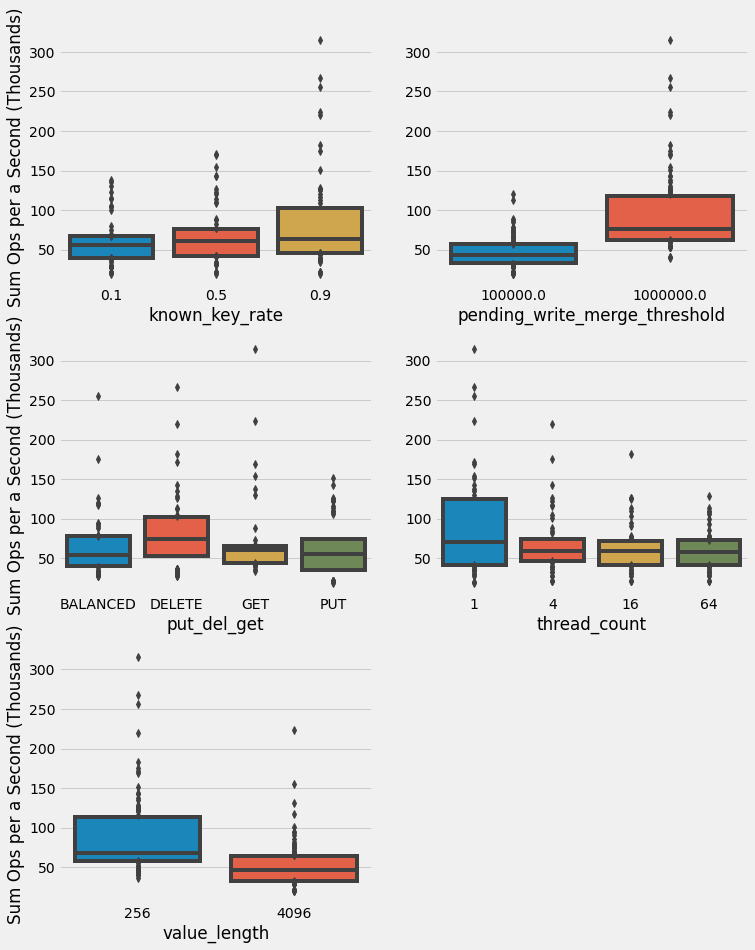

In [15]:
fig = plt.figure(figsize=(11,15))
x = norm_agg['lsm']['sum'].copy()
cols = sorted(set(x.index.names) -
              {'key_length', 'type', 'parent_capacity', 'leaf_capacity', 'vacuum_threshold', 'base_index_rate'})
x = x.reset_index()
x['put_del_get'] = x['put_del_get'].str.replace('_HEAVY', '')
for i,col in enumerate(cols):
    ax = fig.add_subplot(3, 2, i + 1)
    sns.boxplot(ax=ax, x=col, y="50%",
                  data=x,
                  whis=0)
    #plt.ylim(-0.5, 6.5)
    plt.ylabel('Sum Ops per a Second (Thousands)' if i%2==0 else '')

In [16]:
x = norm_agg['lsm']['get'].reset_index()
x = x[x['put_del_get'] == 'GET_HEAVY']
x.sort_values('50%', ascending=False)

,key_length,value_length,put_del_get,known_key_rate,thread_count,pending_write_merge_threshold,base_index_rate,type,count,mean,std,min,25%,50%,75%,max
65,16,256,GET_HEAVY,0.9,1,1000000.0,10.0,lsm,10.0,266.578000,2.282288,262.84,265.1225,267.980,268.1450,268.63
161,16,4096,GET_HEAVY,0.9,1,1000000.0,10.0,lsm,9.0,189.896667,2.601408,186.32,187.9300,190.390,190.6300,194.62
57,16,256,GET_HEAVY,0.5,1,1000000.0,10.0,lsm,8.0,144.045000,0.366450,143.24,143.9750,144.135,144.2225,144.44
153,16,4096,GET_HEAVY,0.5,1,1000000.0,10.0,lsm,6.0,131.135000,1.267387,129.11,130.4750,131.405,132.0500,132.46
49,16,256,GET_HEAVY,0.1,1,1000000.0,10.0,lsm,8.0,116.838750,0.334768,116.20,116.7775,116.865,117.0500,117.25
145,16,4096,GET_HEAVY,0.1,1,1000000.0,10.0,lsm,10.0,110.670000,0.636536,109.28,110.4300,110.880,110.9825,111.46
64,16,256,GET_HEAVY,0.9,1,100000.0,10.0,lsm,6.0,75.125000,0.345355,74.81,74.8675,75.005,75.3300,75.67
160,16,4096,GET_HEAVY,0.9,1,100000.0,10.0,lsm,8.0,62.156250,0.838927,60.55,61.8875,62.565,62.7300,62.78
51,16,256,GET_HEAVY,0.1,4,1000000.0,10.0,lsm,9.0,57.015556,0.832663,55.46,56.3000,57.340,57.7300,57.87
147,16,4096,GET_HEAVY,0.1,4,1000000.0,10.0,lsm,8.0,56.361250,1.021126,54.81,55.5825,56.390,57.3275,57.52


In [17]:
x = {"put":3138426,
     "delete":1569044,
     "deleteFound":1569044,
     "get":26684492,
     "getFound":911581}
pd.Series(x)[op_cols] / 60 / 1000

put        52.307100
delete     26.150733
get       444.741533
dtype: float64

In [18]:
time=625.0 
x = {"put":12555521,"delete":6279984,"deleteFound":6279984,"get":106749502,"getFound":1148989}
pd.Series(x)[op_cols] / time / 1000

put        20.088834
delete     10.047974
get       170.799203
dtype: float64